<h1> Python for Raster Analysis </h1>

<p> A Notebook to demonstrate the efficiency of Numpy for Raster Analysis. After opening the the Raster data set using GDAL, common geogrpahical raster analysis workflows are demonstrated using Numpy for fast calculations and processing.</p>


In [1]:
# necessary Imports
import os
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

# geodata specific imports
import gdal
import rasterio

<h2> Open multi-band tiff and visualize it</h2>
<p> Fist, we want to check out the area we are woring in, in a way we are used to see it. As a true-color (RGB) image. Therefore we will open the 3-band rgb TIFF from our directory and read the single bands as arrays. This way we can use Matplotlib to visualise the image by stacking the three arrays to a rgb Image. </p>

In [4]:
# open multiband tiff using Rasterio
raster = rasterio.open('sample_data/Sentinel_2_Rome/2019-08-29, Sentinel-2A L2A, True color.tiff')

In [5]:
# Convert each band to a numpy array
red = raster.read(1)
green = raster.read(2)
blue = raster.read(3)

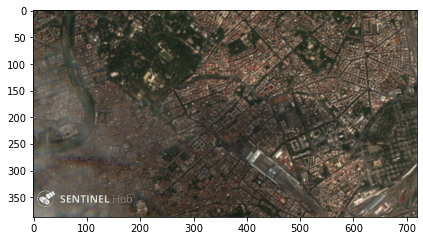

In [6]:
# stack bands to from 3 band true Color image
trueColor = np.dstack((red, green, blue))

#show image
plt.imshow(trueColor)
plt.tight_layout()


<h3> Create multiband array from single band images (e.g. received from Sentinel HUB) </h3>
<p> Similar to Rasterio you can also use GDAL to open your datasets. In this case we will open all single-band tiff scenes in a folder to create a multi-band array containing the combined information. </p>

In [9]:
# funtion to read single band tiff and convert to array
def openTiff_singleBand(file_path):
    # read tiff file and extract relevant geotransform data
    ds = gdal.Open(file_path)
    gt= ds.GetGeoTransform()

    # define Raster Band 1 and save as array
    im_array = np.array(ds.GetRasterBand(1).ReadAsArray())

    # replace value -99999 with NoData
    im_array = np.where(im_array == -99999, np.nan, im_array)
    
    return im_array, gt

# function to normalize data
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

In [10]:
multiBand = []
bands = []

directory = "sample_data/Sentinel_2_Rome/August_2019"
# loop over directory and open all single band tiffs
for filename in os.listdir(directory):
    #check if file is a tiff
    if filename.endswith(".tiff"): 
        file_path = os.path.join(directory, filename)
        # open tiff and return array
        array, _ = openTiff_singleBand(file_path)
        array = normalize(array)
        multiBand.append(array)
        bands.append(filename[-8:-5])

print("Bands loaded: ", bands)
# create multiband numpy array
multiBand = np.array(multiBand)

Bands loaded:  ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A']


<h2> What Bands are available? </h2>
<p> By comparing the output of the cell above to the list of available Bands for Sentinel-2, we can quickly see, that band 10 is missing in the files provided. This band is not available for download at Sentinel Hub. All other available bands have sucesfully been loaded. By accessing the single arrays within the "multiBand" Array we can have a look at single bands. Just play around and change the index in the cell below. Note that due to band 10 missing, in Order to see the following bands type the accoring number:
Band 11: 10
Band 12: 11
Band 8A: 12</p>
<img src=https://www.researchgate.net/profile/Gordana_Jovanovska_Kaplan/publication/314119510/figure/tbl1/AS:670480428195846@1536866399263/Sentinel-2-band-characteristics.png height=250 >



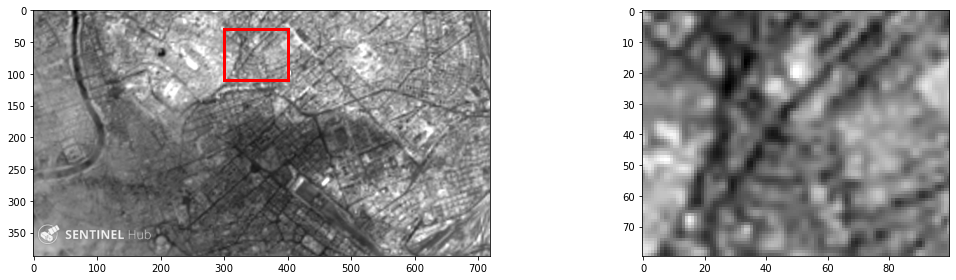

In [33]:
# change band to see refelctance in different wavelengths

band = 12

#plot image and zoom in window in image
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.imshow(multiBand[band-1], cmap='gray')
ax2.imshow(multiBand[band-1][30:110, 300:400], cmap='gray')
rect = patches.Rectangle((300,30),100,80, linewidth=3,edgecolor='r',facecolor='none')
ax1.add_patch(rect)
plt.tight_layout()

<h2> Reduce Bands to those we need</h2>
<p> For this Notebook we will only need Bands red-2, green-3, blue-4, NIR-8, SWIR-11, SWIR-12. All other bands (1, 5, 6, 7, 9, 8A) can be remove in order to make the amount of data we work with smaller. </p> 

In [14]:
# create list of Bands to Keep
bands_keep = ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']

# create filter based on list this will return a True-False array in the shape of the MultiBand array stating "True" for the elements to keep
band_filter = np.isin(bands, bands_keep)

# use filter to reduce oridinal multiband array 
relevant_bands = multiBand[band_filter]


<h1> Raster Analysis </h1>

Now, that we have inspected and 
<h2> Split Multiband Array into single bands to work with</h2>
<p> If you want to use the bands as single arrays, like we are going to do. We actually don't need to load them all into a multi-band array. We would rather load them as individual files and save each band as a sepearte array. But sometime your data will be a single tiff containing all bands. In which case the above steps might be usefull to inspect anf filter the data. To now get a single array for each band we will simple access the multi band array and save the entries based on their index. </p>

In [15]:
red = relevant_bands[0]
green = relevant_bands[1]
blue = relevant_bands[2]
nir = relevant_bands[3]
swir_11 = relevant_bands[4]
swir_12 = relevant_bands[5]

<h3> Calculate Products from bands</h3>
<p> Now that we have all the single bands, raster analysis similiar to using a GIS can be done. Calculations similar to the "Raster Calulator" in GIS Software can be conducted or False Color Composits can be inspected by combining different bands for visualization. </p>
<h4>False Color Urban composite</h4>
<p>This composite uses both SWIR bands and the red band. As vegetation reflects SWIR band 11, it is visible in shades of green, while urbanized areas, which reflect all 3, are represented by white, gray, or purple. Soils, sand, and minerals are shown in a variety of colors. Due to the almost complete absorption of solar radiation in the middle IR range by water, snow, and ice, coastlines and water objects are well distinguished. Snow and ice appear as dark blue, and water as black or blue. SWIR bands are also useful for detecting wildfires, as they are reflected by heated areas (source: Sentinel Hub).</p>

<h4>False color composite</h4>
<p>False color composite using near infrared, red and green bands is very popular. It is most commonly used to assess plant density and health, as plants reflect near infrared and green light, while absorbing red. Since they reflect more near infrared than green, plant-covered land appears deep red. Denser plant growth is darker red. Cities and exposed ground are gray or tan, and water appears blue or black (source: Sentinel Hub).</p>


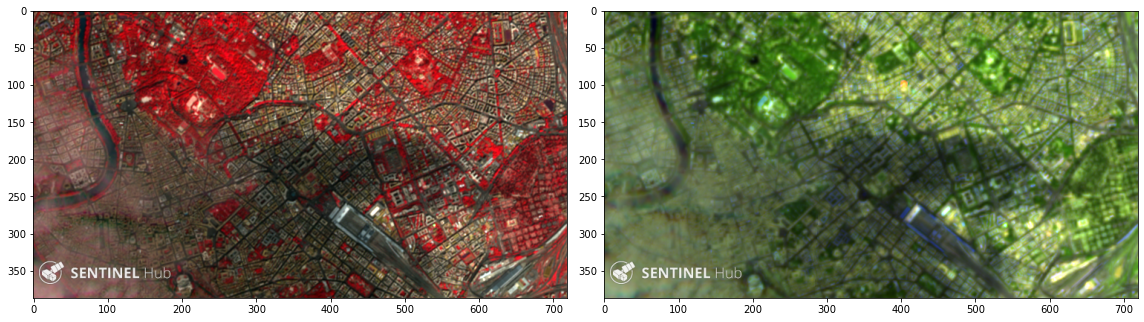

In [27]:
# False Color images

# stack bands to from False Color Image for Vegetation
vegColor = np.dstack((nir, blue, green))

# stack bands to from False Color Image for Urband Areas
urbanColor = np.dstack((swir_12, swir_11, blue))

fig = plt.figure(figsize=(16,7))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(vegColor)
ax2.imshow(urbanColor)
plt.tight_layout()

<h2> Raster Calculation </h2>
<p> Visualization can already be a powerful insight into the area of interest. But to actually perform analysis on the data, indices like the Normalized Difference vegetation Index (NDVI) or the Normalize Difference Water Index (NDWI) can be calulated through raster multiplication, addition,subtraction and division. Similar to a Raster Calulator tool the bands can be as single instances, and each cell will be calculated with the corresponding cells in each band.</p>
<h4>Normalized Difference Vegetation Index (NDVI)</h4>
<p>The well known and widely used NDVI is a simple, but effective index for quantifying green vegetation. It normalizes green leaf scattering in Near Infra-red wavelengths with chlorophyll absorption in red wavelengths. The value range of the NDVI is -1 to 1. Negative values of NDVI (values approaching -1) correspond to water. Values close to zero (-0.1 to 0.1) generally correspond to barren areas of rock, sand, or snow. Low, positive values represent shrub and grassland (approximately 0.2 to 0.4), while high values indicate temperate and tropical rainforests (values approaching 1) (source: Sentinel Hub).</p>

<h4>Normalized Difference Water Index (NDWI)</h4>
<p>The NDWI index is most appropriate for water body mapping. The water body has strong absorbability and low radiation in the range from visible to infrared wavelengths. The index uses the green and Near Infra-red bands of remote sensing images based on this phenomenon.Values of water bodies are larger than 0.5. Vegetation has smaller values. Built-up features have positive values between zero and 0.2 (source: Sentinel Hub).</p>

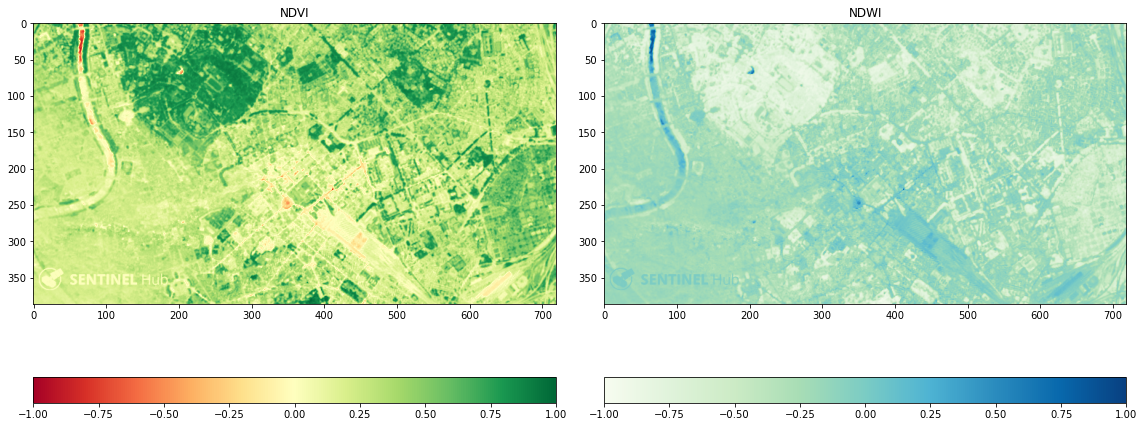

In [26]:
# caclulate NDVI
ndvi = (nir - red) / (nir + red)

# calculate moisture index
ndwi = (green - nir) / (green + nir)

# Visualization

fig = plt.figure(figsize=(16,7))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(ndvi, cmap="RdYlGn")
ax2.imshow(ndwi, cmap="GnBu")
ax1.title.set_text('NDVI')
ax2.title.set_text('NDWI')
norm = cm.colors.Normalize(vmax=1, vmin=-1)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="RdYlGn"), ax=ax1, orientation="horizontal")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="GnBu"), ax=ax2, orientation="horizontal")
plt.tight_layout()